In [3]:
from utilities import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints, transforms
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

## Time Series as a Regression Problem

In [4]:
co2_by_month = pd.read_csv(os.path.abspath('.') + '/data/monthly_mauna_loa_co2.csv')
co2_by_month["date_month"] = pd.to_datetime(co2_by_month["date_month"])
co2_by_month["CO2"] = co2_by_month["CO2"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]

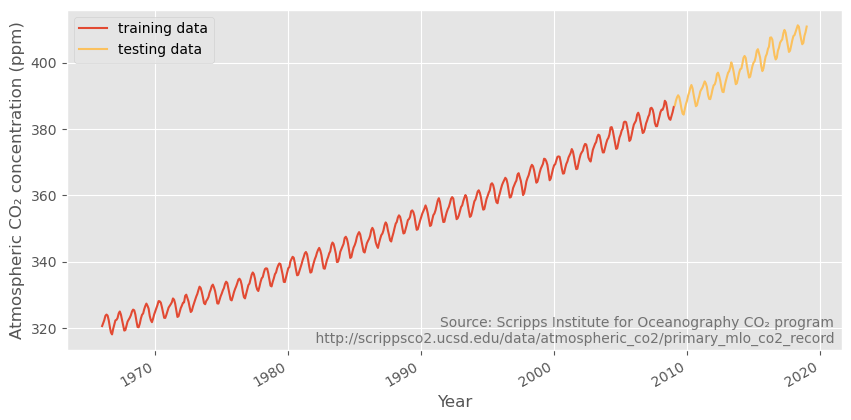

In [5]:
def plot_co2_data(fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(co2_by_month_training_data, label="training data")
    ax.plot(co2_by_month_testing_data, color="C4", label="testing data")
    ax.legend()
    ax.set(
        ylabel="Atmospheric CO₂ concentration (ppm)",
        xlabel="Year"
    )
    ax.text(0.99, .02,
            """Source: Scripps Institute for Oceanography CO₂ program
            http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record""",
            transform=ax.transAxes,
            horizontalalignment="right",
            alpha=0.5)
    fig.autofmt_xdate()
    return fig, ax


_ = plot_co2_data()

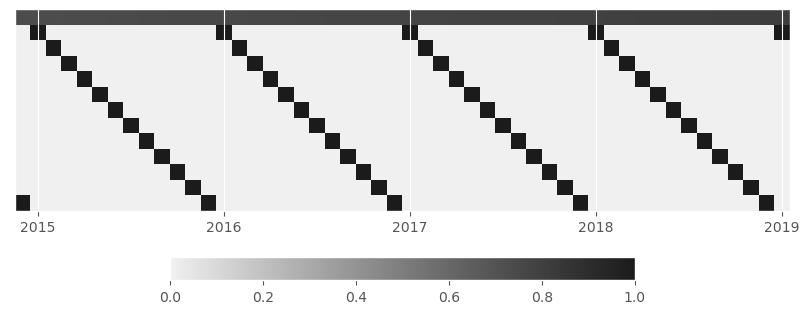

In [6]:
trend_all = np.linspace(0., 1., len(co2_by_month)).reshape(-1, 1)
trend_all = trend_all.astype(np.float32)
trend = trend_all[:-num_forecast_steps, :]

seasonality_all = pd.get_dummies(
    co2_by_month.index.month).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

fig, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, cmap='cet_gray_r')

label_loc = np.arange(1, 50, 12)
ax.set_xticks(label_loc)
ax.set_yticks([])
ax.set_xticklabels(co2_by_month.index.year[-50:][label_loc])
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=.6)

In [7]:
seasonality = torch.tensor(seasonality, dtype=torch.float64).float()
trend = torch.tensor(trend, dtype=torch.float64).float()
co2 = torch.tensor(co2_by_month_training_data.values.flatten(), dtype=torch.float64).float()

In [10]:
def ts_regression_model(trend, seasonality, obs=None):

    intercept = pyro.sample('intercept', dist.Normal(0., 100.))
    trend_coef = pyro.sample('trend_coef', dist.Normal(0., 10.).expand([trend.shape[-1]]))
    noise = pyro.sample('noise', dist.HalfCauchy(0.1, 5.))
    
    with pyro.plate('seasonality', seasonality.shape[-1]):
        season_coef = pyro.sample('season_coef', dist.Normal(0., 1.))

    y_hat = intercept + torch.matmul(trend_coef, trend.T) + torch.matmul(season_coef, seasonality.T)
    
    with pyro.plate('co2', len(trend)):
        #y_hat = intercept + torch.mul(trend_coef, trend) + torch.matmul(season_coef, seasonality.T)
        observed = pyro.sample('observed', dist.Normal(y_hat, noise), obs=obs)

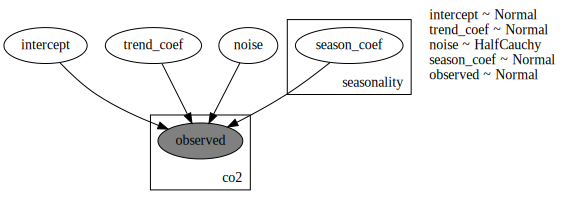

In [11]:
pyro.render_model(ts_regression_model, (trend, seasonality, co2), render_distributions=True)

In [12]:
kernel = NUTS(ts_regression_model)
mcmc_regression = MCMC(kernel, 500, 100)
mcmc_regression.run(trend, seasonality, co2)

Sample: 100%|██████████| 600/600 [08:07,  1.23it/s, step size=5.99e-04, acc. prob=0.952]


In [27]:
mcmc_regression.summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept    317.37      0.28    317.37    316.90    317.80     27.73      1.00
          noise      1.58      0.05      1.58      1.50      1.66    338.61      1.00
 season_coef[0]      0.15      0.34      0.13     -0.39      0.71     43.64      1.00
 season_coef[1]      0.73      0.33      0.72      0.23      1.31     32.26      1.02
 season_coef[2]      1.37      0.30      1.40      0.87      1.82     45.48      1.00
 season_coef[3]      2.51      0.35      2.53      1.96      3.07     45.60      1.00
 season_coef[4]      2.91      0.33      2.93      2.40      3.46     36.80      1.00
 season_coef[5]      2.28      0.35      2.28      1.76      2.91     42.75      1.00
 season_coef[6]      0.79      0.33      0.78      0.31      1.38     33.68      1.01
 season_coef[7]     -1.23      0.35     -1.24     -1.81     -0.71     39.02      1.00
 season_coef[8]     -2.97      0.35     -2.97     -3.

In [28]:
ts_samples = mcmc_regression.get_samples(1000)
post_samples = Predictive(ts_regression_model, ts_samples)(trend, seasonality, None)
az_ts_model = az.from_pyro(posterior=mcmc_regression, posterior_predictive=post_samples)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


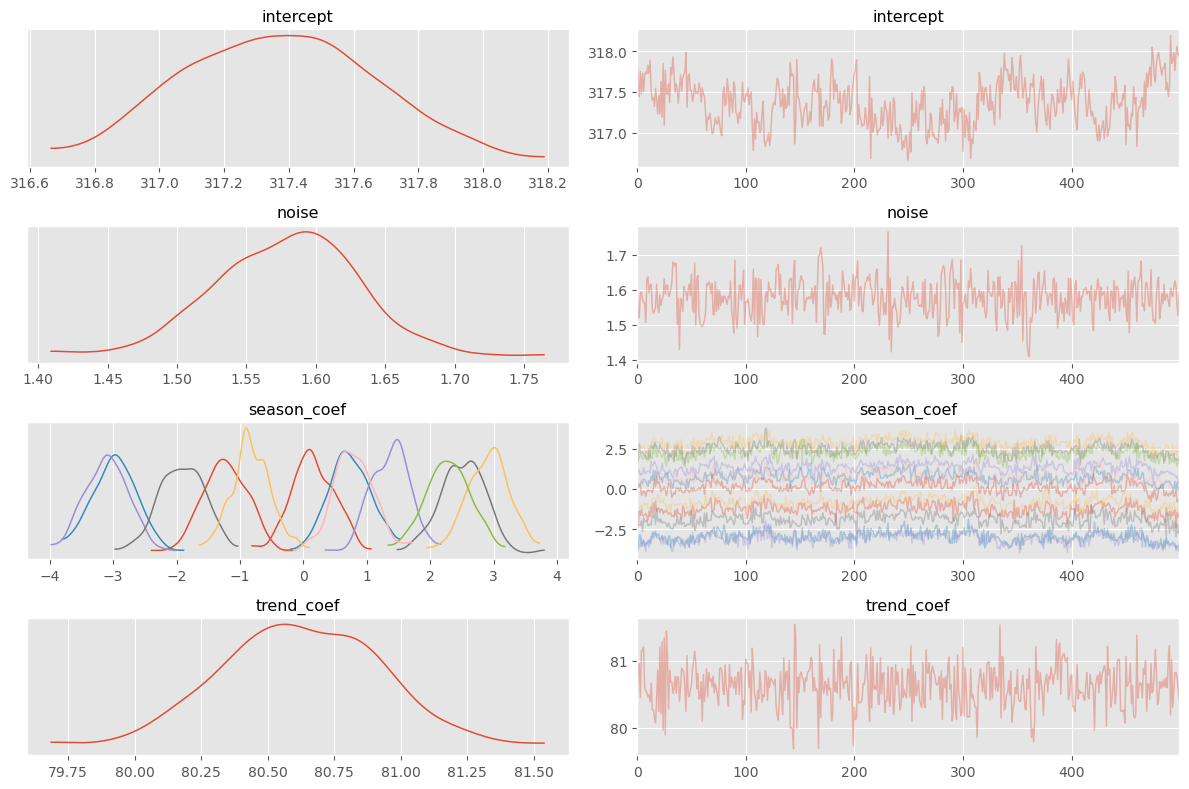

In [29]:
az.plot_trace(az_ts_model)
plt.tight_layout()

In [30]:
# prior samples
prior_samples = Predictive(ts_regression_model, {}, num_samples=100)(trend, seasonality)

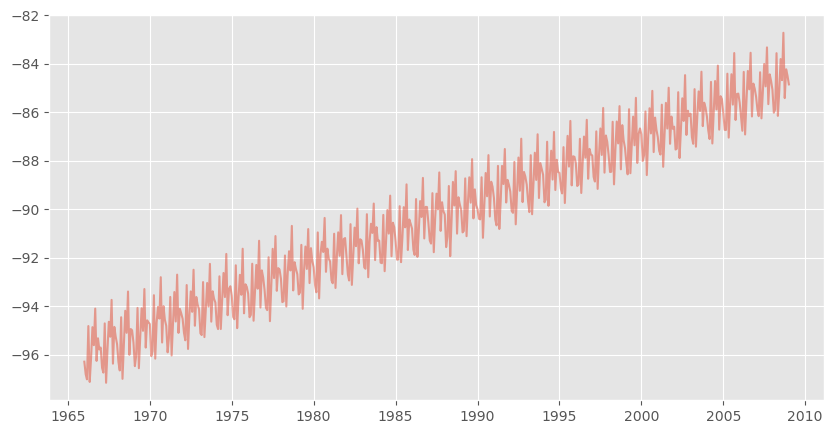

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month_training_data.index, prior_samples['observed'][0].T,
    alpha=0.5
    )
plt.show()

In [32]:
trend_posterior = ts_samples['intercept'] + torch.mul(ts_samples['trend_coef'].mean(), trend)
season_posterior = torch.matmul(ts_samples['season_coef'], seasonality.T)

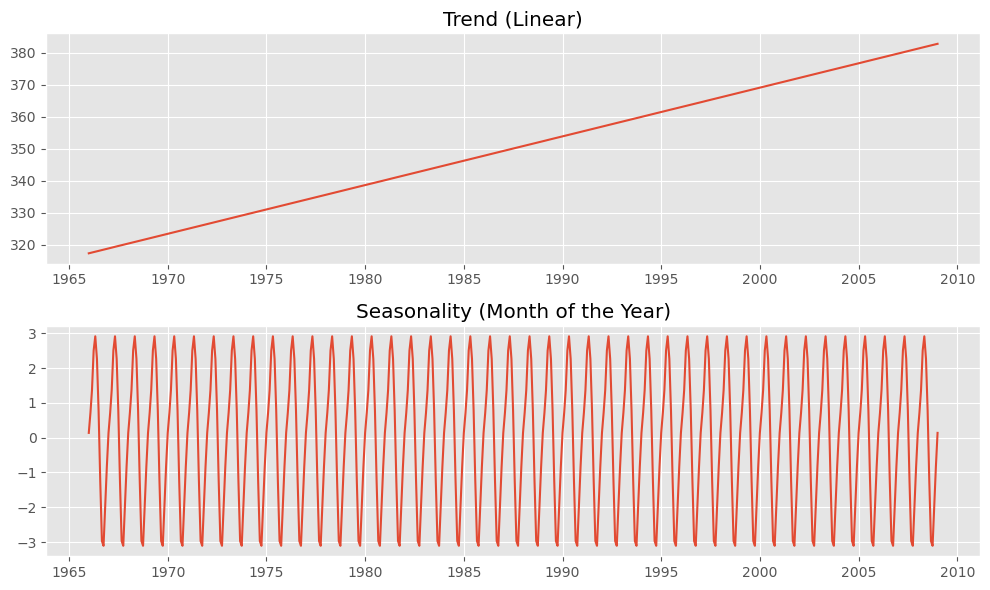

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(
    co2_by_month_training_data.index, 
    trend_posterior.mean(axis=1)
    )

ax[1].plot(
    co2_by_month_training_data.index,
    season_posterior.mean(axis=0)
)

ax[0].set_title('Trend (Linear)')
ax[1].set_title('Seasonality (Month of the Year)')
plt.tight_layout()
plt.show()

In [ ]:
trend_all = torch.tensor(trend_all, dtype=torch.float64).float()
seasonality_all = torch.tensor(seasonality_all, dtype=torch.float64).float()

In [38]:
post_samples = Predictive(ts_regression_model, ts_samples)(trend_all, seasonality_all, None)

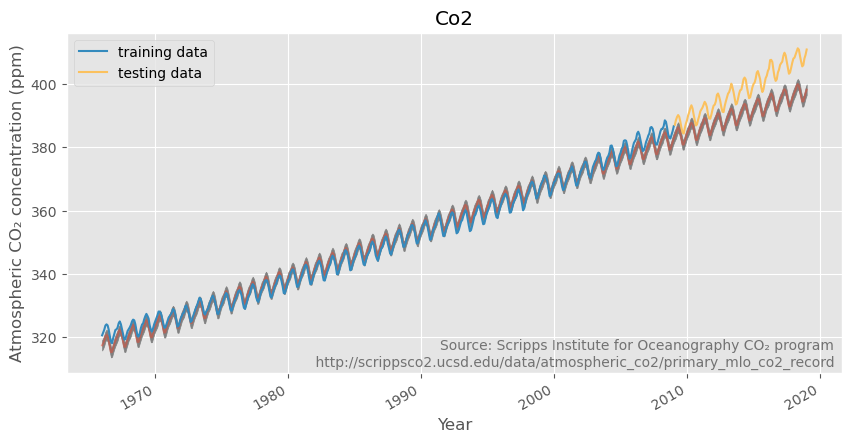

In [47]:
high = post_samples['observed'].mean(axis=0) + post_samples['observed'].std(axis=0)
low = post_samples['observed'].mean(axis=0) - post_samples['observed'].std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(
    co2_by_month.index, post_samples['observed'].mean(axis=0),
    alpha=0.5
    )
ax.fill_between(x=co2_by_month.index, y1=high, y2=low, color='grey')
ax.set_title('Co2')
plot_co2_data((fig, ax))
plt.show()

### Design Matrices for Time Series

In [8]:
n_changepoints = 8
n_tp = 500
t = np.linspace(0, 1, n_tp)
s = np.linspace(0, 1, n_changepoints + 2)[1:-1] ## doesn't subset first and last element
A = (t[:, None] > s) ## is val > changepoint val

k, m = 2.5, 40
delta = np.random.laplace(.1, size=n_changepoints) ## rate adj.
growth = (k + A @ delta) * t
offset = m + A @ (-s * delta)
trend = growth + offset

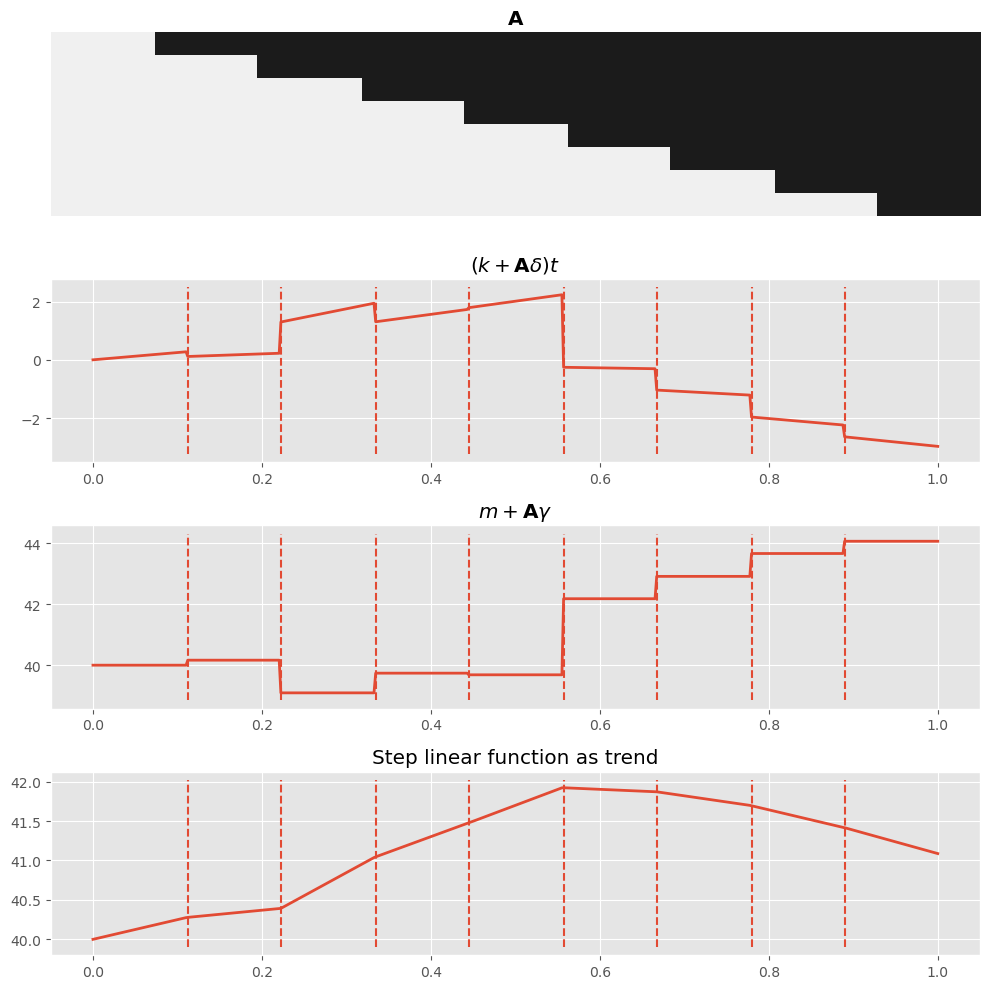

In [11]:
_, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].imshow(A.T, cmap="cet_gray_r", aspect='auto', interpolation='none');
ax[0].axis('off')
ax[0].set_title(r'$\mathbf{A}$')
ax[1].plot(t, growth, lw=2)
ax[1].set_title(r'$(k + \mathbf{A}\delta) t$')
ax[2].plot(t, offset, lw=2)
ax[2].set_title(r'$m + \mathbf{A} \gamma$')
ax[3].plot(t, trend, lw=2);
ax[3].set_title('Step linear function as trend');

lines = [np.where(t > s_)[0][0] for s_ in s]
for ax_ in ax[1:]:
    ax_.vlines(t[lines], *ax_.get_ylim(), linestyles='--');

plt.tight_layout()

### Basis Functions and Generalized Additive Model

**NOT FINISHED**

In [12]:
def gen_fourier_basis(t, p=365.25, n=3):
    x = 2 * torch.pi * (torch.arange(n) + 1) * t[:, None] / p

    return torch.concatenate((torch.cos(x), torch.sin(x)), axis=1)

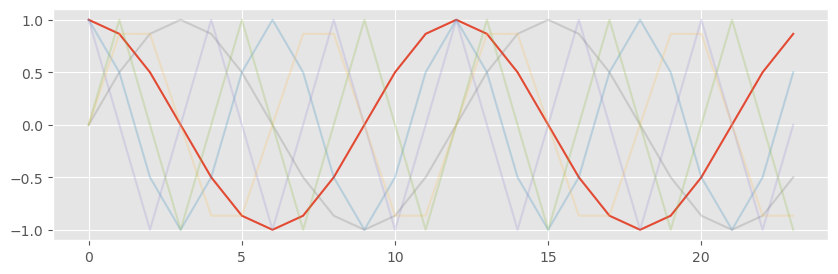

In [13]:
n_tp = 500
p = 12
t_monthly = np.asarray([i % p for i in range(n_tp)])
monthly_X = gen_fourier_basis(t_monthly, p=p, n=3)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(monthly_X[:p*2, 0])
ax.plot(monthly_X[:p*2, 1:], alpha=.25)
plt.show()

In [14]:
n_changepoints = 12
n_tp = seasonality.shape[0]
t = torch.linspace(0, 1, n_tp, dtype=torch.float64)
s = torch.linspace(0, max(t), n_changepoints + 2, dtype=torch.float64)[1:-1]
A = torch.tensor((t[:, None] > s), dtype=torch.float64)

/var/folders/rl/y69t95y51g90tvd6gjzzs59h0000gn/T/ipykernel_1431/1592386469.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor((t[:, None] > s), dtype=torch.float64)


In [16]:
X_pred = gen_fourier_basis(
    torch.where(seasonality)[1],
    p=seasonality.shape[-1],
    n=6
)

n_pred = X_pred.shape[-1]

In [18]:
mean_CO2 = torch.tensor(co2_by_month_training_data.reset_index()['CO2'].mean())

In [29]:
beta = dist.Normal(0., 1.).expand([12]).sample().type(dtype=torch.float64)

k = dist.HalfNormal(10.).sample()
delta = dist.Laplace(0., dist.HalfNormal(10.).sample()).expand([12]).sample().type(dtype=torch.float64)

seasonality = torch.matmul(X_pred.type(dtype=torch.float64), beta)

growth_rate = k + torch.matmul(A, delta)

m = dist.Normal(mean_CO2, scale=5.).sample()
gamma = -s.type(dtype=torch.float64) * delta

offset = m + torch.matmul(A.type(dtype=torch.float64), gamma)
trend = torch.matmul(growth_rate, t.type(dtype=torch.float64)) + offset

y_hat = torch.add(seasonality, trend)

In [30]:
X_pred.shape, seasonality.shape, growth_rate.shape, offset.shape, trend.shape

(torch.Size([517, 12]),
 torch.Size([517]),
 torch.Size([517]),
 torch.Size([517]),
 torch.Size([517]))

In [72]:
def gam(fourier_x, mean_co2, A, s, t, obs=None):

    N, P = fourier_x.shape
    num_changepoints = 12

    k = pyro.sample('k', dist.HalfNormal(10.))
    m = pyro.sample('m', dist.Normal(float(mean_co2), scale=5.))
    tau = pyro.sample('tau', dist.HalfNormal(10.))

    with pyro.plate('season', P):
        beta = pyro.sample('beta', dist.Normal(0., 1.))
        delta = pyro.sample('delta', dist.Laplace(0., tau))

    seasonality = torch.matmul(fourier_x.type(dtype=torch.float64), beta.type(dtype=torch.float64))
    growth_rate = k + torch.matmul(A.type(dtype=torch.float64), delta.type(dtype=torch.float64))
    gamma = -s * delta.type(dtype=torch.float64).type(dtype=torch.float64)
    offset = m + torch.matmul(A, gamma)
    trend = torch.matmul(growth_rate, t.type(dtype=torch.float64)) + offset

    y_hat = torch.add(seasonality, trend)
    noise_sigma = pyro.sample('noise_sigma', dist.HalfNormal(5.))
    
    with pyro.plate('obs', N):
        observed = pyro.sample('output', dist.Normal(y_hat, noise_sigma), obs=obs)

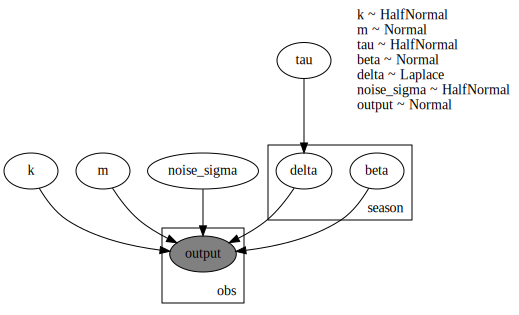

In [73]:
pyro.render_model(gam, (X_pred, mean_CO2, A, s, t, co2), render_distributions=True)

In [ ]:
kernel = NUTS(gam)
mcmc_gam = MCMC(kernel, 500, 300)
mcmc_gam.run(X_pred, mean_CO2, A, s, t, co2)

In [63]:
mcmc_gam.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta[0]     -0.51      0.01     -0.52     -0.53     -0.50      6.74      1.00
      beta[1]      0.18      0.06      0.16      0.11      0.28      3.20      1.84
      beta[2]     -0.87      0.04     -0.86     -0.95     -0.82      3.13      1.96
      beta[3]      0.09      0.04      0.09      0.05      0.16      4.52      1.20
      beta[4]     -0.15      0.02     -0.15     -0.19     -0.12      4.25      1.33
      beta[5]      0.08      0.03      0.08      0.02      0.12      5.89      1.01
      beta[6]      2.03      0.02      2.03      1.99      2.06      5.46      1.12
      beta[7]     -0.15      0.03     -0.16     -0.19     -0.12      3.42      2.51
      beta[8]      0.05      0.08      0.04     -0.06      0.17      5.09      1.36
      beta[9]      0.23      0.04      0.25      0.17      0.27      3.78      1.43
     beta[10]     -0.62      0.11     -0.64     -0.75     -0.46      2.49  

In [64]:
prior_samples = Predictive(gam, {}, num_samples=500)(X_pred, mean_CO2, A, s, t, None)

In [65]:
gam_samples = mcmc_gam.get_samples(1000)
gam_predictive = Predictive(gam, gam_samples)(X_pred, mean_CO2, A, s, t, None)
az_gam = az.from_pyro(posterior=mcmc_gam, posterior_predictive=gam_predictive)

/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


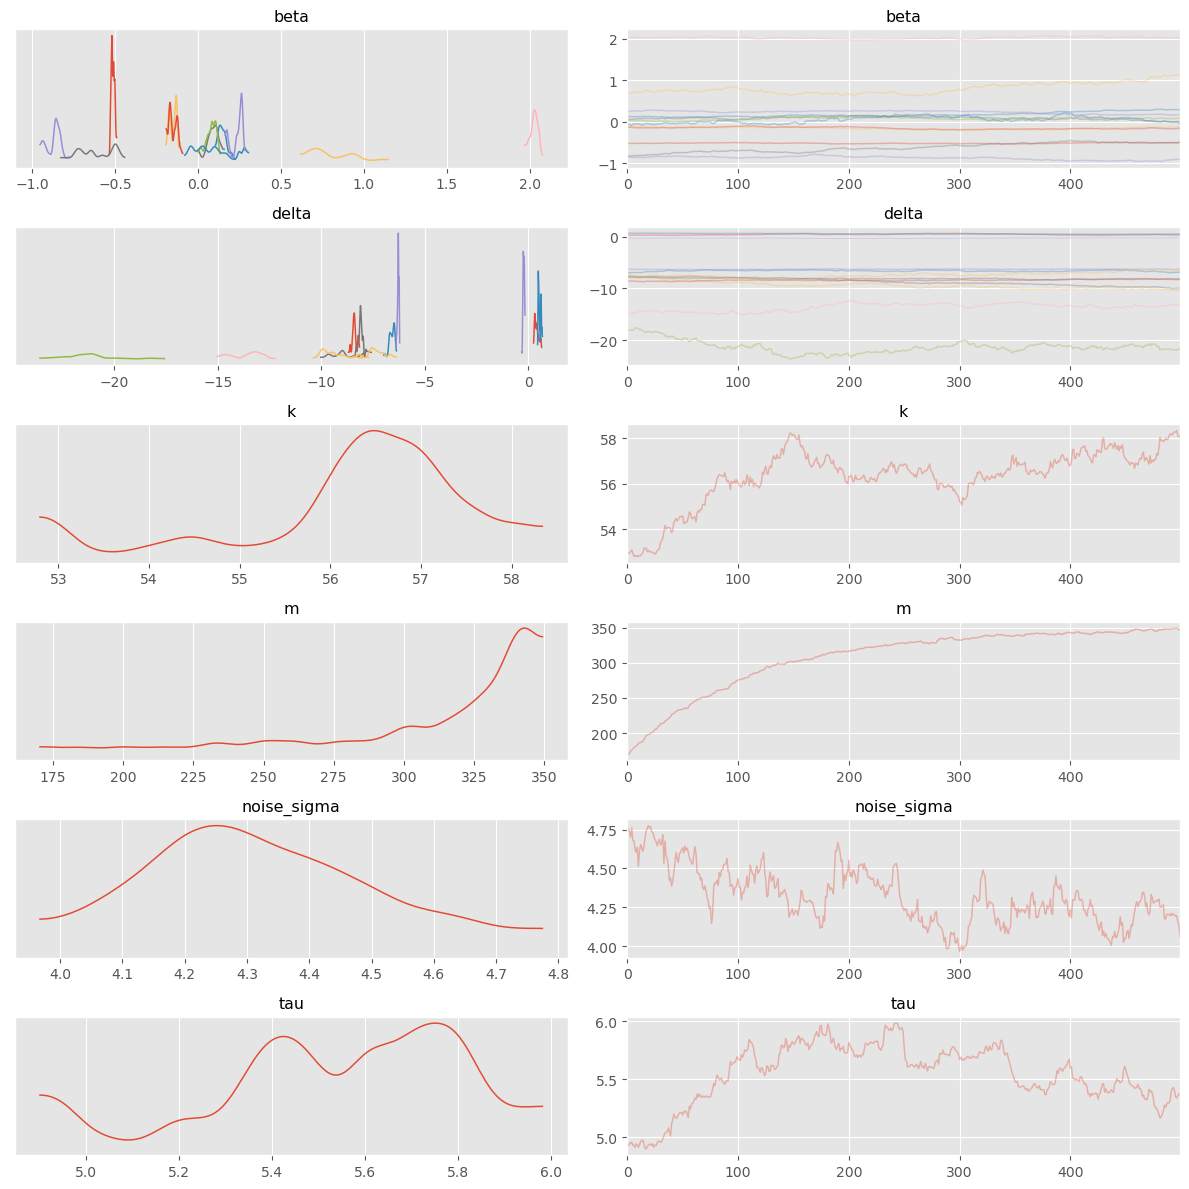

In [66]:
az.plot_trace(az_gam)
plt.tight_layout()
plt.show()

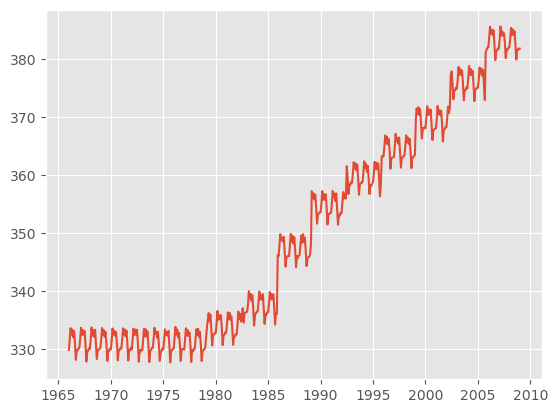

In [70]:
plt.plot(co2_by_month_training_data.index, gam_predictive['output'].mean(axis=0))

## Autoregressive Models

**NOT FINISHED**

In [2]:
def ar1_with_forloop(rho):
    n_t = 200
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    x0 = pyro.sample('x0', dist.Normal(0., sigma))
    x = [x0]

    for i in range(1, n_t):
        x_i = pyro.sample('x_i', dist.Normal(x[i-1] * rho, sigma))
        x.append(x_i)
    
    return x

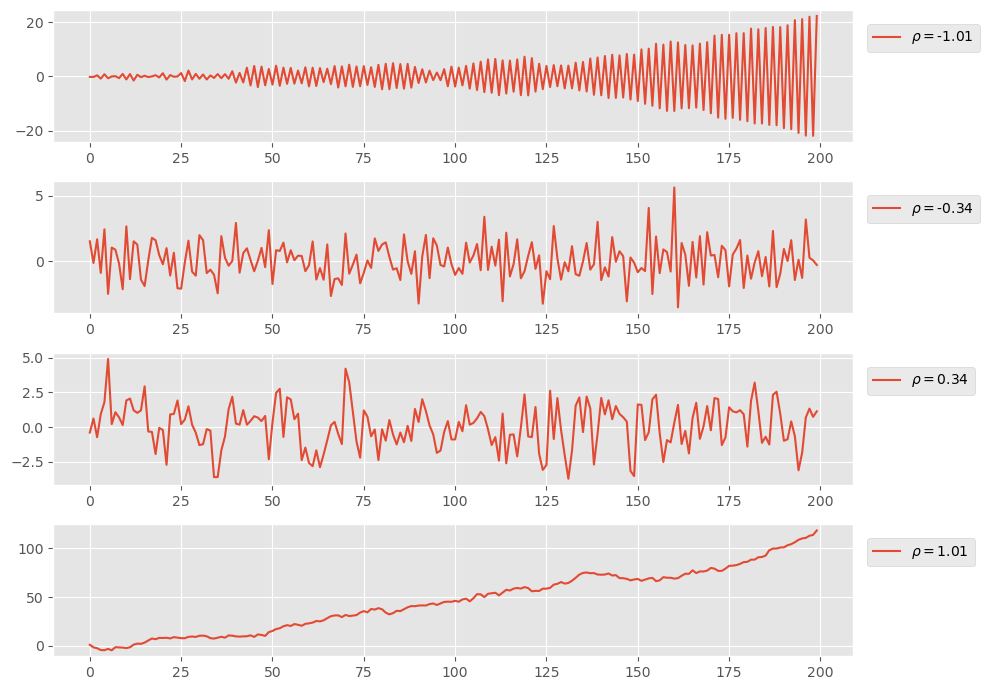

In [3]:
nplot = 4
fig, axes = plt.subplots(nplot, 1, figsize=(10, 7))

for ax, rho in zip(axes, torch.linspace(-1.01, 1.01, nplot)):
    output = ar1_with_forloop(rho=rho)
    ax.plot(torch.arange(0, 200), output, label=r'$\rho=$%.2f' % rho)
    ax.legend(
        bbox_to_anchor=(1, 1), loc='upper left',
        borderaxespad=1., fontsize=10
        )
    plt.tight_layout()

### Latent AR Process and Smoothing

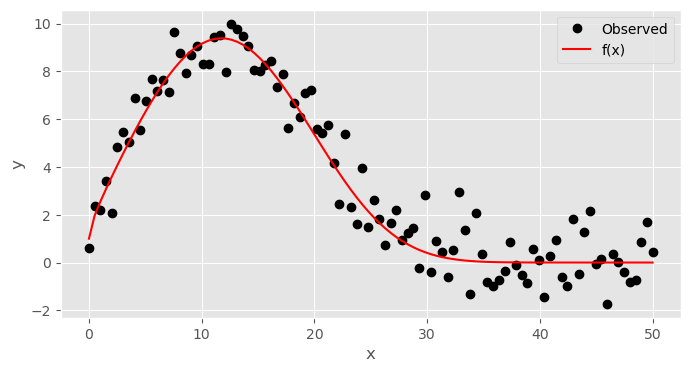

In [119]:
num_steps = 100

x = np.linspace(0, 50, num_steps)
f = np.exp(1.0 + np.power(x, 0.5) - np.exp(x/15.0))
y = f + np.random.normal(scale=1.0, size=x.shape)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'ok', label='Observed')
plt.plot(x, f, 'r', label='f(x)')
plt.legend()
plt.xlabel('x');
plt.ylabel('y');

In [231]:
def smoothing_grw(num_steps, obs=None):
    alpha = pyro.sample('alpha', dist.Beta(1., 1.))
    variance = pyro.sample('variance', dist.HalfNormal(10.))
    sigma_0 = torch.sqrt(variance * alpha)
    sigma_1 = torch.sqrt(variance * (1. - alpha))
    z = pyro.sample('z', dist.Normal(0., sigma_0).expand([num_steps]))

    with pyro.plate('obs', num_steps):

        output = pyro.sample(
            'output', dist.Normal(torch.cumsum(z, axis=-1), sigma_1[..., None]), obs=obs)


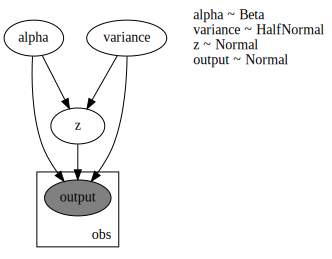

In [232]:
pyro.render_model(smoothing_grw, (num_steps, torch.tensor(y, dtype=torch.float64)), render_distributions=True)

In [233]:
kernel = NUTS(smoothing_grw)
mcmc_smoothing_grw = MCMC(kernel, 300, 100)
mcmc_smoothing_grw.run(num_steps, torch.tensor(y, dtype=torch.float32))

Sample: 100%|██████████| 400/400 [00:55,  7.24it/s, step size=3.16e-02, acc. prob=0.875]


In [235]:
grw_samples = mcmc_smoothing_grw.get_samples(1000)
grw_posterior_predictive = Predictive(smoothing_grw, grw_samples)(num_steps, None)

In [236]:
grw_posterior_predictive['output'].mean(axis=0).shape

torch.Size([100])

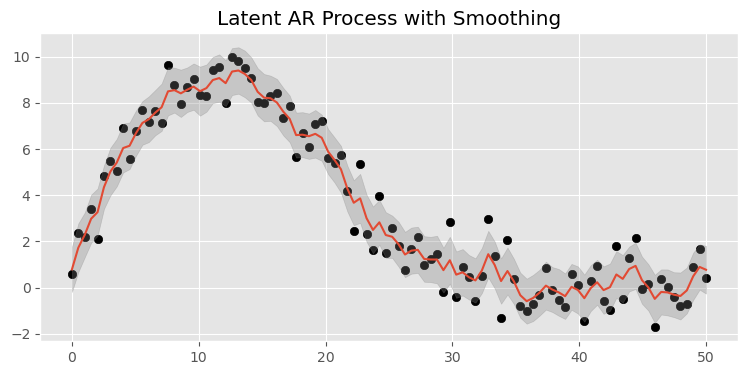

In [238]:
mean = grw_posterior_predictive['output'].mean(axis=0)
std = grw_posterior_predictive['output'].std(axis=0)

plt.figure(figsize=(9, 4))
plt.plot(x, grw_posterior_predictive['output'].mean(axis=0))
plt.scatter(x, y, color='black')
plt.fill_between(x, mean + std, mean - std, alpha=0.30, color='grey')
plt.title('Latent AR Process with Smoothing')
plt.show()